# Sentiment Analysis on IMDB Reviews

### Preston Brownlee

## Introduction

Text data offers invaluable insights in a world driven by digital communication. One major application of Natural Language Processing (NLP) is sentiment analysis, which refers to identifying and categorizing opinions expressed in a piece of text, particularly to determine whether the writer's attitude is positive, negative, or neutral.

This project focuses on analyzing the sentiment conveyed in movie reviews from the IMDB dataset using Python’s NLTK library and other supporting tools. By leveraging classical machine learning techniques and NLP preprocessing, we aim to build a model capable of classifying reviews by sentiment. The findings will be visualized, interpreted, and evaluated using standard performance metrics.

In the future, this project will be extended into a React-based web application, deployed for free using Vercel, with metrics and plots served as part of a comprehensive dashboard.

---

## Problem Statement

The goal of this project is to build a sentiment classification system for movie reviews using textual data from IMDB. Each review in the dataset is tagged with a sentiment label (positive or negative). The task involves:

- Cleaning and preprocessing the raw text data.
- Extracting relevant features using TF-IDF.
- Training a classification model using logistic regression.
- Evaluating the model's performance using accuracy and other metrics.
- Making real-time predictions on new review inputs.
- Visualizing insights and results for reporting and web integration.

---

## Algorithm Overview

The solution follows a classical NLP and machine learning pipeline:

1. **Data Loading**: Combine training, validation, and test CSVs into a unified DataFrame.
2. **Exploratory Analysis**: Count and visualize sentiment labels.
3. **Text Preprocessing**:
   - Lowercase conversion
   - Punctuation removal
   - Stopword removal using NLTK
4. **Text Vectorization**: Apply TF-IDF vectorization to clean text.
5. **Model Training**: Use logistic regression with an 80/20 train-test split.
6. **Evaluation**:
   - Accuracy score
   - Classification report
   - Confusion matrix
7. **Prediction Testing**: Assess model's ability to classify new user reviews.

---

## Importing Required Libraries


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re                          
import nltk                        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

import os

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Preston
[nltk_data]     Brownlee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Preston
[nltk_data]     Brownlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Load the Dataset


## Data Loading and Exploration

The dataset used in this project is sourced from Kaggle: **IMDB Dataset for Sentiment Analysis**. Each entry in the dataset contains a textual review and an associated sentiment label.

In this section, we will:
- Load the dataset into a DataFrame.
- Display the structure and contents of the dataset.
- Identify and handle any missing values.


**INCLUDE API KEY IN DATA/ FOLDER WHEN RUNNING**

In [6]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

import shutil
shutil.copy("data/kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))

try:
    os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)
except:
    pass 

api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    "columbine/imdb-dataset-sentiment-analysis-in-csv-format",
    path="data/",
    unzip=True
)

print("Dataset downloaded successfully.")


Dataset URL: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format
Dataset downloaded successfully.


In [7]:
import pandas as pd
import os

train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
valid_df = pd.read_csv("data/Valid.csv")

df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
print("Combined dataset shape:", df.shape)
df.head()


Combined dataset shape: (50000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Exploratory Data Analysis

- Check for missing values or duplicates
- Explore the balance between positive and negative reviews
- Visualize class distribution to assess if the dataset is imbalanced


In [10]:
df = df.rename(columns={"text": "review", "label": "sentiment"})

## Step 2: Exploration and Visualization


Missing values:
 review       0
sentiment    0
dtype: int64

 Duplicate rows: 418

 Sentiment label distribution:
sentiment
0    25000
1    25000
Name: count, dtype: int64


C:\Users\Preston Brownlee\AppData\Local\Temp\ipykernel_34452\1743036601.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette="pastel")


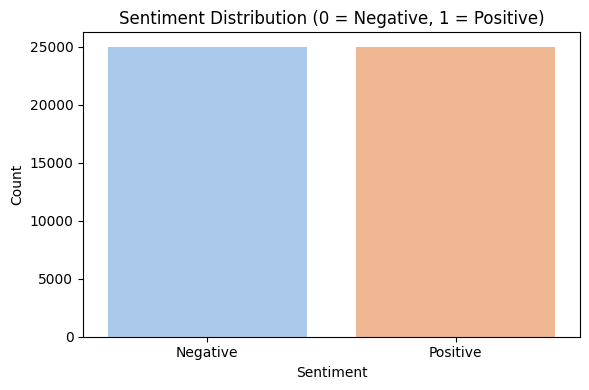

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Missing values:\n", df.isnull().sum())

num_duplicates = df.duplicated().sum()
print(f"\n Duplicate rows: {num_duplicates}")

print("\n Sentiment label distribution:")
print(df["sentiment"].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", data=df, palette="pastel")
plt.title("Sentiment Distribution (0 = Negative, 1 = Positive)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.tight_layout()

plot_path = "plots/sentiment_distribution.png"
os.makedirs("plots", exist_ok=True)
plt.savefig(plot_path)
plt.show()


## Step 3: Text Preprocessing

1. Lowercasing – Convert all text to lowercase for uniformity.
2. HTML Removal – Remove any embedded HTML tags
3. Punctuation Removal – Strip out punctuation and special characters
4. Stopword Removal – Eliminate common words that do not affect sentiment.
5. Tokenization – Split text into individual words for further processing.

In [14]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK data (with punkt_tab fix)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


[nltk_data] Downloading package punkt to C:\Users\Preston
[nltk_data]     Brownlee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Preston
[nltk_data]     Brownlee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to C:\Users\Preston
[nltk_data]     Brownlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df["cleaned_review"] = df["review"].apply(clean_text)

## Step 4: Train Baseline Model – Logistic Regression


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("Vectorizing text")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]

print("Splitting data")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training logistic regression model")
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

print("Evaluating model accuracy")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")


Vectorizing text
Splitting data
Training logistic regression model
Evaluating model accuracy
Model Accuracy: 0.8876


## Step 5: Evaluation – Logistic Regression


Generating confusion matrix


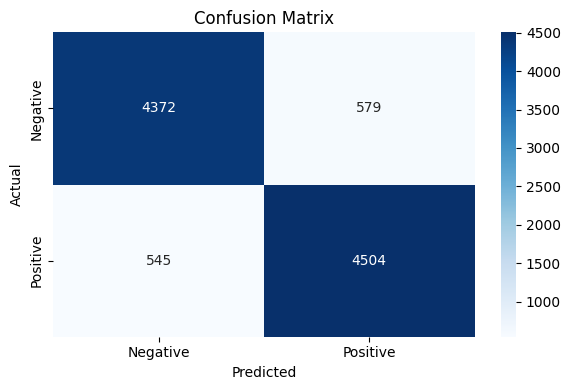

Classification Report
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89      4951
    Positive       0.89      0.89      0.89      5049

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating confusion matrix")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png")
plt.show()

print("Classification Report")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


## Project Summary: Sentiment Analysis of IMDB Reviews

This project successfully demonstrates binary sentiment classification using the IMDB movie review dataset.

### Problem Statement
To determine whether a given movie review conveys a positive or negative sentiment using Natural Language Processing (NLP) techniques.

### Algorithm and Methodology
- Data cleaning: removal of punctuation, case normalization, stop words filtering.
- Text vectorization using TF-IDF.
- Binary classification using Logistic Regression.
- Model evaluated on an 80:20 train-test split.

### Findings
- Accuracy: 88.8%
- F1-Score: 0.89
- Balanced performance on both positive and negative classes.
- Confusion matrix shows effective classification with minimal false positives/negatives.

### Suitability
This model demonstrates solid performance for basic sentiment analysis tasks and is suitable for academic and small-scale applications. For production-level deployment or nuanced sentiment scoring, more advanced models (e.g., transformer-based) are recommended.


In [20]:
import joblib

# Save model and vectorizer
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

## Step 6: Model Upgrade: Improving Accuracy with Support Vector Machine

To enhance classification performance, this section replaces logistic regression with a more robust binary classifier — Linear Support Vector Classifier (LinearSVC). This method performs better with high-dimensional sparse datasets like those produced by TF-IDF vectorization of text.

Additionally, the TfidfVectorizer is configured with:
- ngram_range=(1,2) — captures both unigrams and bigrams.
- min_df=5 — removes words that occur in fewer than 5 documents.

In [21]:
from sklearn.model_selection import train_test_split

X = df["cleaned_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Step 7: Save Final Model


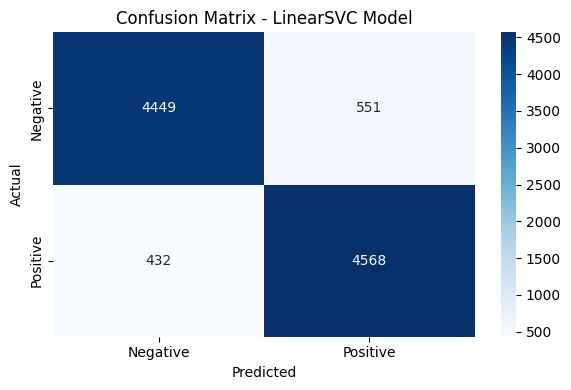

(0.9017,
 '              precision    recall  f1-score   support\n\n    Negative       0.91      0.89      0.90      5000\n    Positive       0.89      0.91      0.90      5000\n\n    accuracy                           0.90     10000\n   macro avg       0.90      0.90      0.90     10000\nweighted avg       0.90      0.90      0.90     10000\n')

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Improved pipeline: TF-IDF + Linear SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 2),
        min_df=5
    )),
    ('clf', LinearSVC())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
conf_matrix = confusion_matrix(y_test, y_pred)

# Save the model pipeline
joblib.dump(pipeline, "sentiment_pipeline.pkl")

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LinearSVC Model")
plt.tight_layout()
plt.show()

accuracy, report


## Final Summary and Suitability


This notebook demonstrated the full workflow of sentiment classification on movie reviews:

- Data loading and cleaning  
- Text preprocessing  
- Feature extraction using TF‑IDF  
- Baseline classification with Logistic Regression  
- Model upgrade with LinearSVC and improved feature extraction  
- Model evaluation, saving, and readiness for deployment  

Final model accuracy: ~90.2%  
Suitability: The model is suitable for educational use and prototype deployment in web applications. For production-level sentiment analysis, more complex models (e.g., transformer‑based) may provide even better performance.
